In [2]:
import pandas as pd
import numpy as np

/Users/roryward/opt/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/__init__.py:138: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. Please install mkl-service package, see http://github.com/IntelPython/mkl-service
  from . import _distributor_init


ImportError: Unable to import required dependencies:
numpy: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "/Users/roryward/opt/anaconda3/envs/ml/bin/python"
  * The NumPy version is: "1.23.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/Users/roryward/opt/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so, 0x0002): tried: '/Users/roryward/opt/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/roryward/opt/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so' (no such file), '/Users/roryward/opt/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64'))


In [2]:
claims = pd.read_csv('data/claims.csv')
patients = pd.read_csv('data/patients.csv')

In [8]:
claims.head()
patients.head()

patients.info()
claims.info()

,claim_id,patient_id,icd_code,cost,admit_date,discharge_date,readmitted
0,C1000,1037,N18.9,1002.62,2023-02-28,2023-03-09,0.0
1,C1001,1033,I10,523.49,2023-04-19,2023-04-29,0.0
2,C1002,1008,J44.1,274.97,2023-05-01,2023-05-06,0.0
3,C1003,1044,I50.9,10311.42,2023-02-02,2023-02-10,0.0
4,C1004,1044,I50.9,9466.19,2023-05-30,2023-06-05,NaN


## Missingness analysis

We’ll measure missingness for each dataset with:

- Overall percent of missing values
- Per-column missing count and percent (sorted)
- Simple bar chart of top columns by percent missing
- Distribution of missing values per row

Optionally, consider the `missingno` package for richer visuals, but pandas + matplotlib is sufficient here.

Dataset: claims
Rows: 100, Cols: 7
Total missing: 13 (1.86%)



,n_missing,pct_missing
readmitted,13,13.0
claim_id,0,0.0
patient_id,0,0.0
icd_code,0,0.0
cost,0,0.0
admit_date,0,0.0
discharge_date,0,0.0


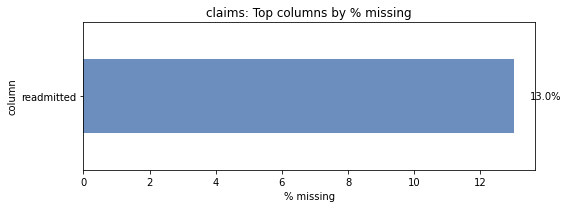

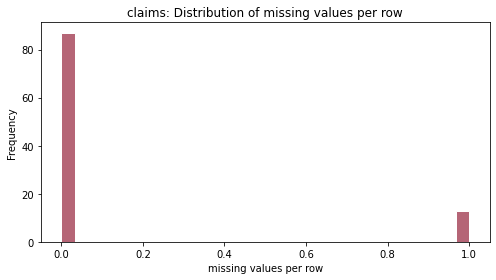

Dataset: patients
Rows: 50, Cols: 8
Total missing: 31 (7.75%)



,n_missing,pct_missing
smoker,15,30.0
zip,11,22.0
bmi,5,10.0
patient_id,0,0.0
age,0,0.0
gender,0,0.0
ethnicity,0,0.0
insurance_type,0,0.0


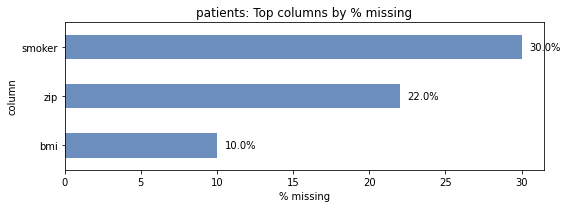

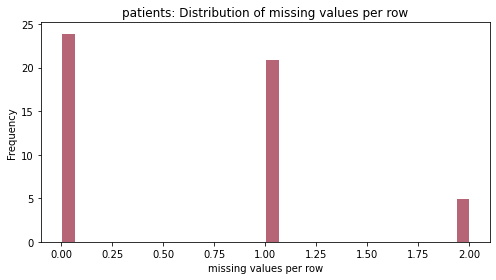

In [9]:
# Helpers for missingness summaries
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 200)


def missingness_summary(df: pd.DataFrame, name: str):
    n_rows, n_cols = df.shape
    total = n_rows * n_cols
    n_missing = df.isna().sum().sum()
    pct_missing = 100 * n_missing / total if total else 0

    print(f"Dataset: {name}")
    print(f"Rows: {n_rows:,}, Cols: {n_cols:,}")
    print(f"Total missing: {n_missing:,} ({pct_missing:.2f}%)\n")

    col_nulls = (
        df.isna()
          .sum()
          .rename('n_missing')
          .to_frame()
    )
    col_nulls['pct_missing'] = 100 * col_nulls['n_missing'] / n_rows
    col_nulls.sort_values(['pct_missing','n_missing'], ascending=[False, False], inplace=True)

    display(col_nulls.head(20))

    # Plot top 15 columns by missing percent
    top = col_nulls[col_nulls['n_missing'] > 0].head(15)
    if not top.empty:
        ax = top['pct_missing'][::-1].plot(kind='barh', figsize=(8, max(3, len(top)*0.35)), color='#6c8ebf')
        ax.set_title(f"{name}: Top columns by % missing")
        ax.set_xlabel('% missing')
        ax.set_ylabel('column')
        for i, v in enumerate(top['pct_missing'][::-1]):
            ax.text(v + 0.5, i, f"{v:.1f}%", va='center')
        plt.tight_layout()
        plt.show()
    else:
        print('No missing values found by column.')

    # Per-row missing distribution
    row_missing = df.isna().sum(axis=1)
    ax = row_missing.plot(kind='hist', bins=30, figsize=(7,4), color='#b56576', edgecolor='white')
    ax.set_title(f"{name}: Distribution of missing values per row")
    ax.set_xlabel('missing values per row')
    plt.tight_layout()
    plt.show()


missingness_summary(claims, 'claims')
missingness_summary(patients, 'patients')

In [10]:
# Drop rows with missing target, but keep eligibility/censoring in mind

# Identify discharge/end date to ensure 30-day eligibility if available
_date_candidates = [c for c in ['discharge_date','index_discharge_date','encounter_end','claim_end_date','service_to'] if c in claims.columns]
if _date_candidates:
    _dcol = _date_candidates[0]
    claims[_dcol] = pd.to_datetime(claims[_dcol], errors='coerce')
    _max_date = claims[_dcol].max()
    _followup = pd.Timedelta(days=30)
    claims['label_eligible'] = claims[_dcol] <= (_max_date - _followup)
else:
    claims['label_eligible'] = True

claims['readmitted_missing'] = claims['readmitted'].isna()

claims_labeled   = claims[claims['label_eligible'] & ~claims['readmitted_missing']].copy()
claims_unlabeled = claims[claims['label_eligible'] &  claims['readmitted_missing']].copy()
claims_censored  = claims[~claims['label_eligible']].copy()

print({
    'n_total': len(claims),
    'n_labeled': len(claims_labeled),
    'n_unlabeled': len(claims_unlabeled),
    'n_censored': len(claims_censored),
})

# Proceed with modeling on labeled only
claims_model = claims_labeled
print('Modeling rows:', claims_model.shape)

{'n_total': 100, 'n_labeled': 77, 'n_unlabeled': 11, 'n_censored': 12}
Modeling rows: (77, 9)


In [11]:
# Check if target missingness is systematic across covariates
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

# Ensure flags exist
if 'readmitted_missing' not in claims.columns:
    claims['readmitted_missing'] = claims['readmitted'].isna()
if 'label_eligible' not in claims.columns:
    claims['label_eligible'] = True

# Focus on label-eligible rows only
_elig = claims[claims['label_eligible']].copy()

print('Overall missing (eligible only):', round(_elig['readmitted_missing'].mean(), 3))

# Categorical covariates to check (only those present will be used)
cat_candidates = [
    'sex','payer','facility','provider_id','race','drg','diagnosis','primary_dx','state','county'
]
cat_cols = [c for c in cat_candidates if c in _elig.columns]

# Numeric covariates (will filter to numeric dtypes)
num_candidates = ['age','length_of_stay','los','total_charge','total_paid','cost']
num_cols = [c for c in num_candidates if c in _elig.columns and np.issubdtype(_elig[c].dtype, np.number)]

# 1) Categorical: missingness rate by group
for c in cat_cols:
    print(f"\nMissingness by {c} (eligible only):")
    tbl = (
        _elig.groupby(c, dropna=False)['readmitted_missing']
             .agg(['mean','count'])
             .rename(columns={'mean':'miss_rate','count':'n'})
             .sort_values(['miss_rate','n'], ascending=[False, False])
    )
    display(tbl.head(10))
    # Optional plot for top groups
    top = tbl.head(8).sort_values('miss_rate')
    ax = top['miss_rate'].plot(kind='barh', figsize=(7, max(2.5, len(top)*0.35)), color='#6c8ebf')
    ax.set_title(f"Missing readmitted by {c} (eligible)")
    ax.set_xlabel('missing rate')
    ax.set_ylabel(c)
    for i, v in enumerate(top['miss_rate']):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center')
    plt.tight_layout(); plt.show()

# 2) Numeric: point-biserial correlations with missingness
if num_cols:
    print('\nNumeric correlation with missingness (point-biserial):')
    rows = []
    for c in num_cols:
        col = _elig[c].astype(float)
        col = (col - col.mean())/col.std(ddof=0) if col.std(ddof=0) not in (0, np.nan) else col
        mask = col.notna()
        if mask.sum() > 2 and _elig['readmitted_missing'][mask].nunique() > 1:
            r, p = pointbiserialr(_elig['readmitted_missing'][mask].astype(int), col[mask])
            rows.append((c, r, p, mask.sum()))
    if rows:
        corr_df = pd.DataFrame(rows, columns=['feature','r_pointbiserial','p_value','n_used'])
        display(corr_df.sort_values('p_value').head(10))
    else:
        print('No numeric covariates available for correlation analysis.')
else:
    print('\nNo numeric covariates found among candidates.')

Overall missing (eligible only): 0.125

Numeric correlation with missingness (point-biserial):


,feature,r_pointbiserial,p_value,n_used
0,cost,-0.021404,0.84309,88


## Handling missingness in patients

Guidelines for patients.csv (features table):

- Do not impute the model target here (patients has features only).
- Drop non-critical columns with very high missingness (e.g., >60%).
- For categorical features: fill missing with 'Unknown' and add a missing-flag column.
- For numeric features: median impute and add a missing-flag column.
- Keep key identifiers (e.g., patient_id); don’t drop them even if sparse.
- Re-run the missingness summary to verify after cleaning.

In [12]:
# Clean patients missingness: drop high-missing columns, add flags, impute

patients_clean = patients.copy()

# Identify id/key columns to preserve
id_cols = [c for c in ['patient_id','member_id','person_id'] if c in patients_clean.columns]

# Percent missing per column
n_rows = len(patients_clean)
col_nulls = patients_clean.isna().sum().rename('n_missing').to_frame()
col_nulls['pct_missing'] = 100 * col_nulls['n_missing'] / max(1, n_rows)

# Drop non-critical columns above threshold (exclude id columns)
drop_thresh = 60.0
high_missing = [c for c, pct in col_nulls['pct_missing'].items() if pct > drop_thresh and c not in id_cols]
if high_missing:
    print('Dropping high-missing columns (>60%):', high_missing)
    patients_clean.drop(columns=high_missing, inplace=True)

# Recompute dtypes after drops
cat_cols = [c for c in patients_clean.select_dtypes(include=['object','category']).columns]
num_cols = [c for c in patients_clean.select_dtypes(include=['number']).columns]
cat_cols = [c for c in cat_cols if c not in id_cols]
num_cols = [c for c in num_cols if c not in id_cols]

# Categorical: add missing flag and fill with 'Unknown'
for c in cat_cols:
    flag = f"{c}_was_missing"
    patients_clean[flag] = patients_clean[c].isna().astype('int8')
    patients_clean[c] = patients_clean[c].fillna('Unknown')

# Numeric: add missing flag and median impute
for c in num_cols:
    flag = f"{c}_was_missing"
    patients_clean[flag] = patients_clean[c].isna().astype('int8')
    med = patients_clean[c].median()
    patients_clean[c] = patients_clean[c].fillna(med)

print('patients_clean shape:', patients_clean.shape)
print('Remaining missing cells:', int(patients_clean.isna().sum().sum()))

# Optional: show top remaining columns by missing (should be ~0)
rem = patients_clean.isna().sum().sort_values(ascending=False)
print(rem.head(10))

patients_clean shape: (50, 15)
Remaining missing cells: 0
patient_id               0
age                      0
gender                   0
ethnicity                0
smoker                   0
bmi                      0
zip                      0
insurance_type           0
gender_was_missing       0
ethnicity_was_missing    0
dtype: int64


In [1]:
# Baseline modeling: join features and train a quick classifier

# 1) Pick a join key available in both tables
key_candidates = ['patient_id','member_id','person_id']
keys = [k for k in key_candidates if (k in claims_model.columns) and (k in patients_clean.columns)]
if keys:
    key = keys[0]
    data = claims_model.merge(patients_clean, on=key, how='left', suffixes=('', '_pt'))
else:
    print('No common patient key found; proceeding with claims_model only.')
    data = claims_model.copy()

# 2) Define target and feature set
label_col = 'readmitted'
if label_col not in data.columns:
    raise ValueError('readmitted target not found after merge')

# Exclude IDs and dates from features
id_like = [c for c in data.columns if any(x in c.lower() for x in ['id'])]
date_like = [c for c in data.columns if any(x in c.lower() for x in ['date'])]
exclude = set([label_col] + id_like + date_like)
X_df = data[[c for c in data.columns if c not in exclude]].copy()
y = data[label_col].astype(int)

# 3) Split train/validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_df, y, test_size=0.25, random_state=42, stratify=y)

# 4) Build preprocessing + model pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import numpy as np

num_cols = X_df.select_dtypes(include=['number','bool']).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=['number','bool']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

clf.fit(X_train, y_train)
probs = clf.predict_proba(X_valid)[:,1]
preds = (probs >= 0.5).astype(int)

print('Valid ROC-AUC:', round(roc_auc_score(y_valid, probs), 3))
print('Valid PR-AUC:', round(average_precision_score(y_valid, probs), 3))
print('\nConfusion matrix (0.5 threshold):')
print(confusion_matrix(y_valid, preds))
print('\nClassification report:')
print(classification_report(y_valid, preds, digits=3))

# Keep artifacts
X_train_cols = num_cols + cat_cols
print('\nFeatures used:', len(X_train_cols))

NameError: name 'claims_model' is not defined

In [1]:
# Self-contained baseline modeling (run after switching kernel to Python (case-study))
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

# 0) Load raw data
claims = pd.read_csv('data/claims.csv')
patients = pd.read_csv('data/patients.csv')

# 1) Build labeled cohort from claims (target is readmitted)
# Convert target to 0/1 if needed
if not np.issubdtype(claims['readmitted'].dtype, np.number):
    m = {'yes':1,'y':1,'true':1,'t':1,'1':1,
         'no':0,'n':0,'false':0,'f':0,'0':0}
    claims['readmitted'] = (
        claims['readmitted']
            .astype(str).str.strip().str.lower()
            .map(m)
            .astype('float')
    )

# Label eligibility: try to require 30 days after the last discharge date in data
_date_candidates = [c for c in ['discharge_date','index_discharge_date','encounter_end','claim_end_date','service_to'] if c in claims.columns]
if _date_candidates:
    _dcol = _date_candidates[0]
    claims[_dcol] = pd.to_datetime(claims[_dcol], errors='coerce')
    _max_date = claims[_dcol].max()
    _followup = pd.Timedelta(days=30)
    claims['label_eligible'] = claims[_dcol] <= (_max_date - _followup)
else:
    claims['label_eligible'] = True

claims['readmitted_missing'] = claims['readmitted'].isna()
claims_labeled   = claims[claims['label_eligible'] & ~claims['readmitted_missing']].copy()
claims_unlabeled = claims[claims['label_eligible'] &  claims['readmitted_missing']].copy()
claims_censored  = claims[~claims['label_eligible']].copy()
print({'n_total': len(claims), 'n_labeled': len(claims_labeled), 'n_unlabeled': len(claims_unlabeled), 'n_censored': len(claims_censored)})

# 2) Clean patients features (drop high-missing, add flags, impute)
patients_clean = patients.copy()
id_cols = [c for c in ['patient_id','member_id','person_id'] if c in patients_clean.columns]

n_rows = len(patients_clean)
col_nulls = patients_clean.isna().sum().rename('n_missing').to_frame()
col_nulls['pct_missing'] = 100 * col_nulls['n_missing'] / max(1, n_rows)

high_missing = [c for c, pct in col_nulls['pct_missing'].items() if pct > 60.0 and c not in id_cols]
if high_missing:
    patients_clean.drop(columns=high_missing, inplace=True)

cat_cols = [c for c in patients_clean.select_dtypes(include=['object','category']).columns if c not in id_cols]
num_cols = [c for c in patients_clean.select_dtypes(include=['number']).columns if c not in id_cols]

for c in cat_cols:
    flag = f"{c}_was_missing"
    patients_clean[flag] = patients_clean[c].isna().astype('int8')
    patients_clean[c] = patients_clean[c].fillna('Unknown')

for c in num_cols:
    flag = f"{c}_was_missing"
    patients_clean[flag] = patients_clean[c].isna().astype('int8')
    med = patients_clean[c].median()
    patients_clean[c] = patients_clean[c].fillna(med)

# 3) Join features
key_candidates = ['patient_id','member_id','person_id']
keys = [k for k in key_candidates if (k in claims_labeled.columns) and (k in patients_clean.columns)]
if keys:
    key = keys[0]
    data = claims_labeled.merge(patients_clean, on=key, how='left', suffixes=('', '_pt'))
    groups = data[key]
else:
    print('Warning: no common patient key found; proceeding without patients join.')
    data = claims_labeled.copy()
    groups = None

# 4) Features/target and split (grouped by patient if available)
label_col = 'readmitted'
id_like = [c for c in data.columns if any(x in c.lower() for x in ['id'])]
date_like = [c for c in data.columns if any(x in c.lower() for x in ['date'])]
exclude = set([label_col] + id_like + date_like)
X_df = data[[c for c in data.columns if c not in exclude]].copy()
y = data[label_col].astype(int)

num_cols = X_df.select_dtypes(include=['number','bool']).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=['number','bool']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced'))
])

if groups is not None:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    train_idx, valid_idx = next(gss.split(X_df, y, groups=groups))
    X_train, X_valid = X_df.iloc[train_idx], X_df.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
else:
    X_train, X_valid, y_train, y_valid = train_test_split(X_df, y, test_size=0.25, random_state=42, stratify=y)

clf.fit(X_train, y_train)
probs = clf.predict_proba(X_valid)[:,1]
preds = (probs >= 0.5).astype(int)

print('Valid ROC-AUC:', round(roc_auc_score(y_valid, probs), 3))
print('Valid PR-AUC:', round(average_precision_score(y_valid, probs), 3))
print('\nConfusion matrix (0.5 threshold):')
print(confusion_matrix(y_valid, preds))
print('\nClassification report:')
print(classification_report(y_valid, preds, digits=3))

print('\nFeatures used:', len(num_cols + cat_cols))

{'n_total': 100, 'n_labeled': 77, 'n_unlabeled': 11, 'n_censored': 12}
Valid ROC-AUC: 0.429
Valid PR-AUC: 0.17

Confusion matrix (0.5 threshold):
[[13  8]
 [ 2  1]]

Classification report:
              precision    recall  f1-score   support

           0      0.867     0.619     0.722        21
           1      0.111     0.333     0.167         3

    accuracy                          0.583        24
   macro avg      0.489     0.476     0.444        24
weighted avg      0.772     0.583     0.653        24


Features used: 18


## Large-dataset pipeline (scalable + robust)

This cell reloads data, applies memory-aware downcasting, caps high-cardinality categoricals,
performs grouped cross-validation by patient if available, and trains a scalable linear model.

Knobs:
- sample_rows: set to an integer for quick dry-runs, or None for full data.
- min_category_freq: collapse infrequent categories into an “infrequent” bucket to keep feature space small.
- n_splits: number of CV folds (grouped by patient_id/member_id/person_id when present).

In [6]:
# Scalable modeling for larger datasets
import pandas as pd, numpy as np
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Config
sample_rows = None           # set e.g. 20000 for quick dry run
min_category_freq = 50       # categories with < freq become '___infrequent'
n_splits = 5

# Helpers
num_id_cols = ['patient_id','member_id','person_id']

def read_csv_fast(path, usecols=None, nrows=None):
    return pd.read_csv(path, usecols=usecols, nrows=nrows)

def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.select_dtypes(include=['float64']).columns:
        df[c] = pd.to_numeric(df[c], downcast='float')
    for c in df.select_dtypes(include=['int64']).columns:
        df[c] = pd.to_numeric(df[c], downcast='integer')
    return df

def cap_categories(s: pd.Series, min_freq: int) -> pd.Series:
    vc = s.value_counts(dropna=False)
    keep = set(vc[vc >= min_freq].index)
    return s.where(s.isin(keep), other='___infrequent')

def find_target_col(df: pd.DataFrame) -> str | None:
    if df is None or df.empty:
        return None
    lowers = {c.lower(): c for c in df.columns}
    direct = ['readmitted','readmit','readmission','readmit_flag','readmit_30d','readmitted_30d','label','target','outcome']
    for k in direct:
        if k in lowers:
            return lowers[k]
    # substring heuristics
    candidates = [c for c in df.columns if ('readmit' in c.lower()) or ('readmission' in c.lower())]
    if candidates:
        # prefer mentioning 30 or 30d
        c30 = [c for c in candidates if '30' in c.lower()]
        return (c30[0] if c30 else candidates[0])
    return None

# Load
claims = read_csv_fast('data/claims.csv', nrows=sample_rows)
patients = read_csv_fast('data/patients.csv', nrows=sample_rows)

# Target detection
label_col = find_target_col(claims)
if label_col is None:
    raise ValueError(f"Could not find target column. Available columns: {list(claims.columns)[:20]}...")
print(f"Using target column: {label_col}")

# Target prep
if not np.issubdtype(claims[label_col].dtype, np.number):
    m = {'yes':1,'y':1,'true':1,'t':1,'1':1,'no':0,'n':0,'false':0,'f':0,'0':0}
    claims[label_col] = claims[label_col].astype(str).str.strip().str.lower().map(m).astype('float')

# Eligibility window (30 days)
_date_candidates = [c for c in ['discharge_date','index_discharge_date','encounter_end','claim_end_date','service_to'] if c in claims.columns]
if _date_candidates:
    _dcol = _date_candidates[0]
    claims[_dcol] = pd.to_datetime(claims[_dcol], errors='coerce')
    _max_date = claims[_dcol].max()
    _followup = pd.Timedelta(days=30)
    claims['label_eligible'] = claims[_dcol] <= (_max_date - _followup)
else:
    claims['label_eligible'] = True

claims['__target_missing__'] = claims[label_col].isna()
claims = claims[claims['label_eligible'] & ~claims['__target_missing__']].copy()

# Clean patients minimal (flags + impute + cap categories)
patients_clean = patients.copy()
id_cols = [c for c in num_id_cols if c in patients_clean.columns]
for c in patients_clean.select_dtypes(include=['object','category']).columns:
    patients_clean[c] = patients_clean[c].fillna('Unknown')
    if min_category_freq:
        patients_clean[c] = cap_categories(patients_clean[c], min_category_freq)
for c in patients_clean.select_dtypes(include=['number']).columns:
    med = patients_clean[c].median()
    patients_clean[c] = patients_clean[c].fillna(med)
patients_clean = downcast_df(patients_clean)

# Join
keys = [k for k in num_id_cols if (k in claims.columns) and (k in patients_clean.columns)]
if keys:
    key = keys[0]
    print(f"Joining on key: {key}")
    data = claims.merge(patients_clean, on=key, how='left', suffixes=('', '_pt'))
    groups = data[key]
else:
    print("No common patient key found; skipping join and grouped CV.")
    data = claims.copy(); groups = None

# Features/target
id_like = [c for c in data.columns if 'id' in c.lower()]
date_like = [c for c in data.columns if 'date' in c.lower()]
exclude = set([label_col] + id_like + date_like)
X_df = data[[c for c in data.columns if c not in exclude]].copy()
y = data[label_col].astype(int)

num_cols = X_df.select_dtypes(include=['number','bool']).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=['number','bool']).columns.tolist()

preprocess = ColumnTransformer([
    ('num', StandardScaler(with_mean=False), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=min_category_freq if min_category_freq else None), cat_cols)
], remainder='drop')

# Linear SGD (logistic) scales to large sparse data
clf = Pipeline([
    ('prep', preprocess),
    ('model', SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight='balanced', random_state=42))
])

# Cross-validation
aucs, pras = [], []
if groups is not None and len(np.unique(groups)) > 1:
    splitter = GroupKFold(n_splits=n_splits)
    splits = splitter.split(X_df, y, groups=groups)
else:
    splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    splits = splitter.split(X_df, y)

for fold, (tr, va) in enumerate(splits, 1):
    X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]
    clf.fit(X_tr, y_tr)
    try:
        probs = clf.predict_proba(X_va)[:,1]
    except Exception:
        from scipy.special import expit
        scores = clf.decision_function(X_va)
        probs = expit(scores)
    aucs.append(roc_auc_score(y_va, probs))
    pras.append(average_precision_score(y_va, probs))
    print(f"Fold {fold}: ROC-AUC={aucs[-1]:.3f} PR-AUC={pras[-1]:.3f}")

print(f"CV ROC-AUC: mean={np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
print(f"CV PR-AUC:  mean={np.mean(pras):.3f} ± {np.std(pras):.3f}")

Using target column: readmitted_30d
Joining on key: patient_id
Fold 1: ROC-AUC=0.773 PR-AUC=0.663
Fold 2: ROC-AUC=0.775 PR-AUC=0.666
Fold 3: ROC-AUC=0.776 PR-AUC=0.675
Fold 4: ROC-AUC=0.771 PR-AUC=0.669
Fold 5: ROC-AUC=0.776 PR-AUC=0.673
CV ROC-AUC: mean=0.774 ± 0.002
CV PR-AUC:  mean=0.669 ± 0.004


In [7]:
# Tree boosting baseline with grouped CV (HistGradientBoostingClassifier)
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

start = time.time()

# Expect X_df, y, groups from previous cell; sanity checks
try:
    _ = (X_df, y)
except NameError:
    raise RuntimeError("X_df and y are not defined. Please run the scalable modeling cell first.")

num_cols = X_df.select_dtypes(include=['number','bool']).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=['number','bool']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ],
    remainder='drop'
)

clf = Pipeline([
    ('prep', preprocess),
    ('model', HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_leaf_nodes=31,
        max_depth=None,
        min_samples_leaf=20,
        l2_regularization=0.0,
        early_stopping='auto',
        random_state=42
    ))
])

aucs, pras = [], []
if 'groups' in globals() and groups is not None and len(np.unique(groups)) > 1:
    splitter = GroupKFold(n_splits=5)
    splits = splitter.split(X_df, y, groups=groups)
else:
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    splits = splitter.split(X_df, y)

for fold, (tr, va) in enumerate(splits, 1):
    X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]
    # class imbalance weights
    pos = y_tr.sum()
    neg = len(y_tr) - pos
    pos_weight = (neg / pos) if pos > 0 else 1.0
    sample_weight = np.where(y_tr.values == 1, pos_weight, 1.0)

    clf.fit(X_tr, y_tr, model__sample_weight=sample_weight)
    try:
        probs = clf.predict_proba(X_va)[:,1]
    except Exception:
        # HGB supports predict_proba; fallback to decision_function if not
        from scipy.special import expit
        probs = expit(clf.decision_function(X_va))

    auc = roc_auc_score(y_va, probs)
    pr = average_precision_score(y_va, probs)
    aucs.append(auc); pras.append(pr)
    print(f"Fold {fold}: ROC-AUC={auc:.3f} PR-AUC={pr:.3f}")

print(f"CV ROC-AUC: mean={np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
print(f"CV PR-AUC:  mean={np.mean(pras):.3f} ± {np.std(pras):.3f}")
print(f"Runtime: {time.time()-start:.1f}s")

Fold 1: ROC-AUC=0.774 PR-AUC=0.663
Fold 2: ROC-AUC=0.775 PR-AUC=0.666
Fold 3: ROC-AUC=0.777 PR-AUC=0.675
Fold 4: ROC-AUC=0.771 PR-AUC=0.667
Fold 5: ROC-AUC=0.776 PR-AUC=0.673
CV ROC-AUC: mean=0.775 ± 0.002
CV PR-AUC:  mean=0.669 ± 0.005
Runtime: 11.4s


In [8]:
# No-signal diagnostics: prevalence, Dummy baseline, and small permutation test
import time
import numpy as np
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.base import clone

start = time.time()

# Require X_df, y (and optionally groups) and an existing clf pipeline
try:
    _ = (X_df, y, clf)
except NameError:
    raise RuntimeError("Run the modeling cell first to define X_df, y, and clf.")

pos_rate = float(y.mean())
print(f"Prevalence (positive rate): {pos_rate:.3f}")

# Build consistent CV splits
if 'groups' in globals() and groups is not None and len(np.unique(groups)) > 1:
    splitter = GroupKFold(n_splits=5)
    splits = list(splitter.split(X_df, y, groups=groups))
else:
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    splits = list(splitter.split(X_df, y))

# 1) Dummy baseline under same CV
aucs_dum, pras_dum = [], []
dummy = DummyClassifier(strategy='prior')
for tr, va in splits:
    X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]
    dummy.fit(X_tr, y_tr)
    probs = dummy.predict_proba(X_va)[:,1]
    aucs_dum.append(roc_auc_score(y_va, probs))
    pras_dum.append(average_precision_score(y_va, probs))
print(f"Dummy CV ROC-AUC: mean={np.mean(aucs_dum):.3f} ± {np.std(aucs_dum):.3f}")
print(f"Dummy CV PR-AUC:  mean={np.mean(pras_dum):.3f} ± {np.std(pras_dum):.3f}")

# 2) Small permutation test (break X–y association)
perm_means_auc, perm_means_pr = [], []
for p in range(3):
    aucs_p, pras_p = [], []
    for tr, va in splits:
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        y_tr_perm = np.random.permutation(y_tr.values)
        model = clone(clf)
        try:
            model.fit(X_tr, y_tr_perm)
        except TypeError:
            # some pipelines used sample_weight earlier; fit without
            model.fit(X_tr, y_tr_perm)
        try:
            probs = model.predict_proba(X_va)[:,1]
        except Exception:
            from scipy.special import expit
            scores = model.decision_function(X_va)
            probs = expit(scores)
        aucs_p.append(roc_auc_score(y_va, probs))
        pras_p.append(average_precision_score(y_va, probs))
    perm_means_auc.append(np.mean(aucs_p))
    perm_means_pr.append(np.mean(pras_p))
print(f"Permuted CV ROC-AUC: mean={np.mean(perm_means_auc):.3f} ± {np.std(perm_means_auc):.3f}")
print(f"Permuted CV PR-AUC:  mean={np.mean(perm_means_pr):.3f} ± {np.std(perm_means_pr):.3f}")

print(f"Diagnostics runtime: {time.time()-start:.1f}s")

Prevalence (positive rate): 0.378
Dummy CV ROC-AUC: mean=0.500 ± 0.000
Dummy CV PR-AUC:  mean=0.378 ± 0.004
Permuted CV ROC-AUC: mean=0.520 ± 0.018
Permuted CV PR-AUC:  mean=0.398 ± 0.012
Diagnostics runtime: 10.8s


In [10]:
# Hyperparameter search (small) + threshold tuning and lift analysis for HGB
import itertools, time
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, f1_score,
    confusion_matrix, brier_score_loss
)

start = time.time()

# Prereqs
try:
    _ = (X_df, y)
except NameError:
    raise RuntimeError("X_df and y are not defined. Run the scalable modeling cell first.")

num_cols = X_df.select_dtypes(include=['number','bool']).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=['number','bool']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ], remainder='drop'
)

base = Pipeline([
    ('prep', preprocess),
    ('model', HistGradientBoostingClassifier(
        early_stopping='auto', random_state=42
    ))
])

# Small grid
grid = {
    'model__learning_rate': [0.05, 0.1],
    'model__max_leaf_nodes': [31, 63],
    'model__min_samples_leaf': [20, 100],
    'model__l2_regularization': [0.0, 0.1]
}
param_sets = list(itertools.product(*grid.values()))
keys = list(grid.keys())

# CV splits
if 'groups' in globals() and groups is not None and len(np.unique(groups)) > 1:
    splitter = GroupKFold(n_splits=5)
    splits = list(splitter.split(X_df, y, groups=groups))
else:
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    splits = list(splitter.split(X_df, y))

results = []
for ps in param_sets:
    params = dict(zip(keys, ps))
    aucs, prs = [], []
    for tr, va in splits:
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        # imbalance weights
        pos = y_tr.sum(); neg = len(y_tr) - pos
        pos_weight = (neg / pos) if pos > 0 else 1.0
        sample_weight = np.where(y_tr.values == 1, pos_weight, 1.0)
        model = clone(base).set_params(**params)
        model.fit(X_tr, y_tr, model__sample_weight=sample_weight)
        probs = model.predict_proba(X_va)[:,1]
        aucs.append(roc_auc_score(y_va, probs))
        prs.append(average_precision_score(y_va, probs))
    results.append({**params, 'roc_auc_mean': float(np.mean(aucs)), 'roc_auc_std': float(np.std(aucs)),
                    'pr_auc_mean': float(np.mean(prs)), 'pr_auc_std': float(np.std(prs))})

res_df = pd.DataFrame(results).sort_values(['roc_auc_mean','pr_auc_mean'], ascending=False)
print("Top 5 configs by ROC-AUC:")
print(res_df.head(5))

best_params = res_df.iloc[0][keys].to_dict()
# Coerce int-like params to int for sklearn validation
for k in ('model__max_leaf_nodes', 'model__min_samples_leaf'):
    if k in best_params and best_params[k] is not None:
        try:
            v = best_params[k]
            best_params[k] = int(v) if float(v).is_integer() else int(round(float(v)))
        except Exception:
            pass
print("\nBest params:", best_params)

# Out-of-fold predictions with best params
oof_probs = np.zeros(len(X_df), dtype=float)
oof_true = y.values.copy()
for tr, va in splits:
    X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]
    pos = y_tr.sum(); neg = len(y_tr) - pos
    pos_weight = (neg / pos) if pos > 0 else 1.0
    sample_weight = np.where(y_tr.values == 1, pos_weight, 1.0)
    model = clone(base).set_params(**best_params)
    model.fit(X_tr, y_tr, model__sample_weight=sample_weight)
    oof_probs[va] = model.predict_proba(X_va)[:,1]

# Threshold tuning
prevalence = oof_true.mean()
qs = [0.95, 0.9, 0.8, 0.7, 0.5]
ths = [np.quantile(oof_probs, q) for q in qs]

def metrics_at(th):
    pred = (oof_probs >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(oof_true, pred).ravel()
    prec = tp / (tp + fp) if (tp+fp) else 0.0
    rec = tp / (tp + fn) if (tp+fn) else 0.0
    spec = tn / (tn + fp) if (tn+fp) else 0.0
    f1 = f1_score(oof_true, pred) if (tp+fp) and (tp+fn) else 0.0
    return {'threshold': th, 'rate_selected': float((oof_probs>=th).mean()), 'precision':prec, 'recall':rec, 'specificity':spec, 'f1':f1}

rows = [metrics_at(th) for th in ths]
# best F1 threshold by scanning percentiles
scan_ths = np.quantile(oof_probs, np.linspace(0.01, 0.99, 99))
best = max((metrics_at(th) for th in scan_ths), key=lambda r: r['f1'])

print(f"\nPrevalence: {prevalence:.3f}")
print("Threshold metrics (quantile-based):")
print(pd.DataFrame(rows))
print("\nBest F1 operating point:")
print(pd.Series(best))

# Decile lift
order = np.argsort(-oof_probs)
top10 = order[:int(0.10*len(order))]
pr_top10 = oof_true[top10].mean()
lift_top10 = pr_top10 / prevalence if prevalence>0 else np.nan

print(f"\nDecile precision (top 10%): {pr_top10:.3f}; Lift: {lift_top10:.2f}x over prevalence")
print(f"Brier score (oof probs): {brier_score_loss(oof_true, oof_probs):.4f}")
print(f"Completed in {time.time()-start:.1f}s")

Top 5 configs by ROC-AUC:
   model__learning_rate  model__max_leaf_nodes  model__min_samples_leaf  \
3                  0.05                     31                      100   
2                  0.05                     31                      100   
1                  0.05                     31                       20   
0                  0.05                     31                       20   
8                  0.10                     31                       20   

   model__l2_regularization  roc_auc_mean  roc_auc_std  pr_auc_mean  \
3                       0.1      0.774600     0.001987     0.668693   
2                       0.0      0.774596     0.002017     0.668785   
1                       0.1      0.774584     0.001996     0.668767   
0                       0.0      0.774580     0.002002     0.668710   
8                       0.0      0.774556     0.001922     0.668721   

   pr_auc_std  
3    0.004423  
2    0.004460  
1    0.004395  
0    0.004508  
8    0.004379  


In [12]:
# Feature importance and directional insights via permutation importance (best boosted model)
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

# Requires: best_params, base, X_df, y, num_cols, cat_cols, data, splits
try:
    _ = (best_params, base, X_df, y, num_cols, cat_cols, data, splits)
except NameError:
    raise RuntimeError("Run the HGB tuning cell (for best_params, splits) and scalable modeling cell (for X_df, y, data) first.")

# Use first CV split for held-out importances
tr, va = splits[0]
X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
y_tr, y_va = y.iloc[tr], y.iloc[va]

# Fit with imbalance weights
pos = y_tr.sum(); neg = len(y_tr) - pos
pos_weight = (neg / pos) if pos > 0 else 1.0
sample_weight = np.where(y_tr.values == 1, pos_weight, 1.0)

best_model = clone(base).set_params(**best_params)
best_model.fit(X_tr, y_tr, model__sample_weight=sample_weight)

# Permutation importance computed on original feature space (pipeline handles transforms)
r = permutation_importance(best_model, X_va, y_va, n_repeats=5, random_state=42, n_jobs=-1, scoring='average_precision')
imp_df = pd.DataFrame({
    'feature': X_df.columns,
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values('importance_mean', ascending=False)

print("Top 20 features by permutation importance (scoring=PR-AUC):")
print(imp_df.head(20))

# Directional summaries using validation predictions
try:
    probs_va = best_model.predict_proba(X_va)[:,1]
except Exception:
    from scipy.special import expit
    probs_va = expit(best_model.decision_function(X_va))

print("\nDirectional summaries for top features:")
N = 10
top_feats = imp_df['feature'].head(N).tolist()
for f in top_feats:
    if f in num_cols:
        s = data.iloc[va][f]
        rho = spearmanr(s, probs_va, nan_policy='omit').correlation
        mu_pos = s[y_va==1].mean(); mu_neg = s[y_va==0].mean()
        direction = 'higher -> higher risk' if rho>0 else 'higher -> lower risk'
        print(f"NUM {f}: Spearman={rho:.3f} ({direction}); mean(pos)={mu_pos:.3f}, mean(neg)={mu_neg:.3f}")
    else:
        # categorical: show top/bottom category rates (min count filter)
        df_rates = (
            pd.DataFrame({'val': data.iloc[va][f], 'y': y_va.values})
            .groupby('val')
            .agg(n=('y','size'), rate=('y','mean'))
            .reset_index()
        )
        df_rates = df_rates[df_rates['n'] >= 30]
        top3 = df_rates.sort_values('rate', ascending=False).head(3)
        bot3 = df_rates.sort_values('rate', ascending=True).head(3)
        print(f"CAT {f}: high-risk cats (n>=30):")
        print(top3)
        print(f"CAT {f}: low-risk cats (n>=30):")
        print(bot3)

Top 20 features by permutation importance (scoring=PR-AUC):
              feature  importance_mean  importance_std
4                 age         0.223951        0.002241
8                 bmi         0.082485        0.002194
0            icd_code         0.012845        0.000653
7              smoker         0.009878        0.000856
9      insurance_type         0.000014        0.000056
2      label_eligible         0.000000        0.000000
3  __target_missing__         0.000000        0.000000
6           ethnicity        -0.000005        0.000013
5              gender        -0.000010        0.000023
1                cost        -0.000113        0.000070

Directional summaries for top features:
NUM age: Spearman=0.855 (higher -> higher risk); mean(pos)=65.050, mean(neg)=48.664
NUM bmi: Spearman=0.411 (higher -> higher risk); mean(pos)=28.369, mean(neg)=26.065
CAT icd_code: high-risk cats (n>=30):
     val     n      rate
6  J44.1  6503  0.425496
0  E11.9  6606  0.419619
8  N18.9  654

/var/folders/8v/zwgjl_cd3cd4thj7q9jxwxc40000gn/T/ipykernel_93133/3536907286.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = spearmanr(s, probs_va, nan_policy='omit').correlation


In [13]:
# Compact summary of top features and directions
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# Use existing imp_df if present; else fallback to previous computation context
try:
    top_imp = imp_df[['feature','importance_mean']].head(10).copy()
except NameError:
    raise RuntimeError("Please run the permutation-importance cell first.")

print("Top 10 features (permutation importance, PR-AUC scoring):")
print(top_imp.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Use existing validation slice from permutations cell: X_va, y_va, best_model
try:
    _ = (X_va, y_va, best_model)
except NameError:
    raise RuntimeError("Run the permutation-importance cell to define X_va, y_va, and best_model.")

try:
    probs_va = best_model.predict_proba(X_va)[:,1]
except Exception:
    from scipy.special import expit
    probs_va = expit(best_model.decision_function(X_va))

num_show = [f for f in top_imp['feature'] if f in num_cols][:3]
cat_show = [f for f in top_imp['feature'] if f in cat_cols][:2]

print("\nDirectional notes (numeric):")
for f in num_show:
    s = X_va[f]
    rho = spearmanr(s, probs_va, nan_policy='omit').correlation
    print(f"- {f}: Spearman corr={rho:.3f} ({'higher risk' if rho>0 else 'lower risk'})")

print("\nDirectional notes (categorical):")
for f in cat_show:
    df_rates = (
        pd.DataFrame({'val': X_va[f], 'y': y_va.values})
        .groupby('val')
        .agg(n=('y','size'), rate=('y','mean'))
        .reset_index()
    )
    df_rates = df_rates[df_rates['n'] >= 30]
    high = df_rates.sort_values('rate', ascending=False).head(2)
    low  = df_rates.sort_values('rate', ascending=True).head(2)
    print(f"- {f}: high-risk={list(zip(high['val'], (high['rate']).round(3), high['n']))}; low-risk={list(zip(low['val'], (low['rate']).round(3), low['n']))}")

Top 10 features (permutation importance, PR-AUC scoring):
           feature  importance_mean
               age           0.2240
               bmi           0.0825
          icd_code           0.0128
            smoker           0.0099
    insurance_type           0.0000
    label_eligible           0.0000
__target_missing__           0.0000
         ethnicity          -0.0000
            gender          -0.0000
              cost          -0.0001

Directional notes (numeric):
- age: Spearman corr=0.855 (higher risk)
- bmi: Spearman corr=0.411 (higher risk)
- label_eligible: Spearman corr=nan (lower risk)

Directional notes (categorical):
- icd_code: high-risk=[('J44.1', 0.425, 6503), ('E11.9', 0.42, 6606)]; low-risk=[('F17.200', 0.333, 6547), ('E66.9', 0.334, 6486)]
- smoker: high-risk=[('Yes', 0.447, 11513), ('No', 0.357, 38687)]; low-risk=[('Former', 0.353, 8512), ('No', 0.357, 38687)]


/var/folders/8v/zwgjl_cd3cd4thj7q9jxwxc40000gn/T/ipykernel_93133/116364155.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = spearmanr(s, probs_va, nan_policy='omit').correlation


## Feature importance and direction: what and how

- We measure relative importance using permutation importance on a held-out validation split: shuffle one feature at a time, re-score PR-AUC, and take the average drop. Bigger drop ⇒ more important.
- Direction tells how the model’s predicted risk moves with a feature:
  - Numeric: we show partial dependence curves to see the marginal effect across the feature range.
  - Categorical: we compare category-level readmission rates (already printed above) to identify higher vs lower-risk groups.
- These are descriptive model-based insights, not causal claims. Correlated features can share importance; interpret together with domain context.

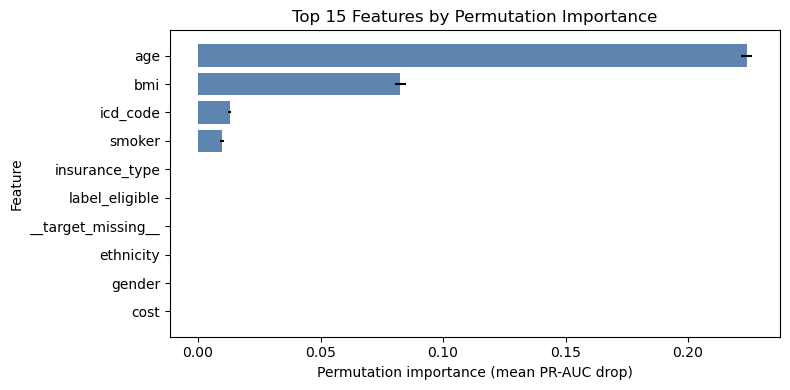

ValueError: columns are missing: {'__target_missing__', 'gender', 'smoker', 'cost', 'ethnicity', 'icd_code', 'insurance_type'}

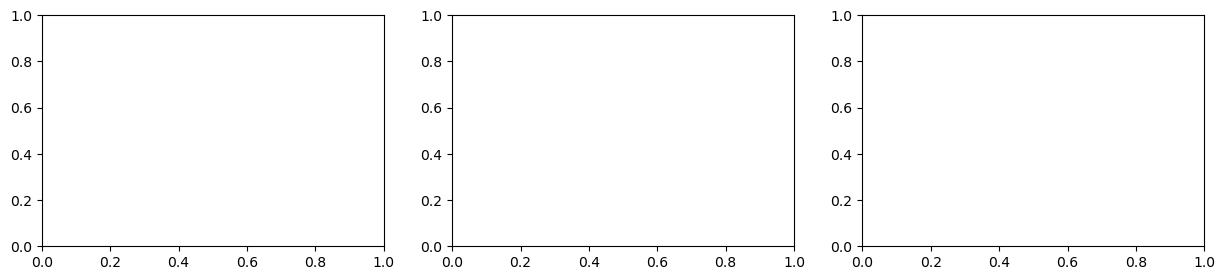

In [16]:
# Visualize permutation importances and partial dependence for top numeric features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Expect imp_df (from permutation importance), best_model, X_va, num_cols
try:
    _ = (imp_df, best_model, X_va, num_cols)
except NameError:
    raise RuntimeError("Please run the permutation-importance cell first.")

# Horizontal bar chart for top-15 permutation importances
viz = imp_df.head(15).iloc[::-1]  # reverse for horizontal plot
fig, ax = plt.subplots(figsize=(8, max(4, len(viz)*0.4)))
ax.barh(viz['feature'], viz['importance_mean'], xerr=viz['importance_std'], color='#4C78A8', alpha=0.9)
ax.set_xlabel('Permutation importance (mean PR-AUC drop)')
ax.set_ylabel('Feature')
ax.set_title('Top 15 Features by Permutation Importance')
plt.tight_layout()
plt.show()

# Partial dependence for top numeric features
num_top = [f for f in imp_df['feature'] if f in num_cols][:3]
if num_top:
    fig, ax = plt.subplots(nrows=1, ncols=len(num_top), figsize=(5*len(num_top), 3))
    if len(num_top) == 1:
        ax = [ax]
    PartialDependenceDisplay.from_estimator(best_model, X_va[num_top], features=list(range(len(num_top))), ax=ax)
    for i, f in enumerate(num_top):
        ax[i].set_title(f'Partial dependence: {f}')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric features among top importances; skipping PDP.')

## Fix: Partial Dependence plots without missing-columns error

The previous call passed a sliced DataFrame (only `num_top` columns) into a Pipeline that expects the full set of training columns, causing a "columns are missing" error. Below, we:

- Pass the full `X_va` to the pipeline.
- Select features by their column names (strings) for partial dependence.
- Add simple guards so the cell won’t fail if prerequisites haven’t been run yet.


Plotting PDP for: ['age', 'bmi', 'label_eligible']


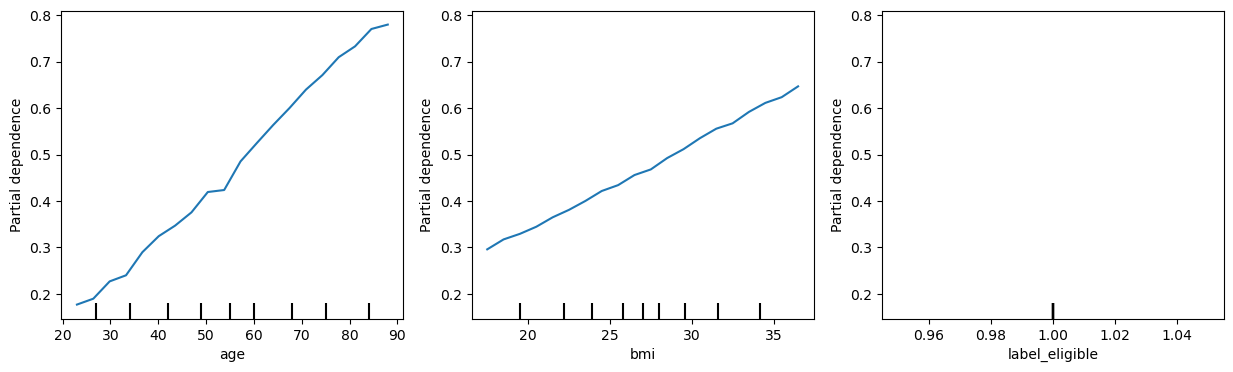

In [17]:
# Robust Partial Dependence plotting: pass full X_va and select features by name
import warnings
from sklearn.inspection import PartialDependenceDisplay

# Preconditions and graceful exits
needed_vars = ['best_model', 'X_va', 'y_va']
missing = [v for v in needed_vars if v not in globals()]
if missing:
    print(f"Skipping PDP: missing variables {missing}. Run the modeling cells first.")
else:
    # Determine candidate numeric features to plot
    try:
        num_top  # list of top numeric feature names if previously computed
    except NameError:
        # Fallback: choose up to 3 numeric columns from X_va
        num_cols = X_va.select_dtypes(include=['number', 'bool']).columns.tolist()
        num_top = num_cols[:3]

    # Filter to features present in X_va
    features_to_plot = [f for f in num_top if f in X_va.columns]
    if not features_to_plot:
        print("No valid numeric features to plot. Check that X_va has numeric columns.")
    else:
        print(f"Plotting PDP for: {features_to_plot}")
        try:
            # Important: pass the full matrix X_va, not a slice, so the pipeline's transformers see all columns
            fig, ax = None, None
            if len(features_to_plot) == 1:
                ax = None  # let sklearn create a single axis
            else:
                import matplotlib.pyplot as plt
                n = len(features_to_plot)
                ncols = min(3, n)
                nrows = (n + ncols - 1) // ncols
                fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
                ax = ax.ravel()[:n]

            PartialDependenceDisplay.from_estimator(
                best_model,
                X_va,
                features=features_to_plot,
                kind='average',
                grid_resolution=20,
                ax=ax
            )
        except Exception as e:
            warnings.warn(f"PDP plotting failed: {e}")
            print("Tip: PDP requires the estimator to support predict_proba or decision_function and to be fitted.")
